<a href="https://colab.research.google.com/github/JacoboGGLeon/RNA/blob/master/parte2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación supervisada con Redes Neuronales Artificiales (RNA)
## UNAM-FES Acatlán, 24 de septiembre, A-723
## Jacobo G. González León
## 09:00 A 13:00
### @jacoboggleon
### Parte 2

Ahora podemos crear una RNA más grande que resuelva algún problema complejo, por ejemplo: clasificar una imagen. Para eso haremos uso del dataset MNIST que consiste en números escritos del 0-9. Cada imagen es de 28x28 pixeles:

<img src="https://docs.google.com/uc?export=download&id=1ZXbJpbCBpV6pBvXTw_ztoaKWLAqagCQf" height= "250">




## Impotar librerías

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch

import helper

import matplotlib.pyplot as plt

El objetivo es construir una RNA que pueda "ver" una de estas imagenes y clasificar el dígito de la imagen.

Necesitamos primero obtener los datos, en este caso a través del paquete `torchvision`

In [0]:
from torchvision import datasets, transforms

Definimos una transformación para normalizar los datos

In [6]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,)), ])
transform

Compose(
    ToTensor()
    Normalize(mean=(0.5,), std=(0.5,))
)

Descargamos entonces los datos y los cargamos en `train`

In [7]:
trainset= datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainset

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 26915327.68it/s]                            


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 445005.16it/s]
  1%|          | 16384/1648877 [00:00<00:11, 143256.90it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 5658270.96it/s]                           
8192it [00:00, 182352.33it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


Dataset MNIST
    Number of datapoints: 60000
    Root location: /root/.pytorch/MNIST_data/
    Split: Train

`batch size` es el número de imagenes es el número de imagenes que vamos a tener en cada iteración a través de nuestra RNA. `shuffle=true` nos permite colocar aleatoriamente nuestros datos. 

In [8]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
trainloader

Tenemos ahora los datos de entrenamiento en `trainloader` y podemos checar los datos

In [9]:
trainloader.dataset.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [10]:
trainloader.dataset.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

Tenemos los datos de entrenamiento cargados en trainloader y lo convertimos en un iterador con iter `trainloader`. Más tarde, usaremos esto para recorrer el conjunto de datos para entrenamiento.

In [11]:
dataiter = iter(trainloader)
dataiter

In [0]:
images, labels = dataiter.next()

Imprimimos el tipo de dato

In [13]:
print(type(images))

<class 'torch.Tensor'>


Las imagenes, que ahora son tensores, tienen las siguientes características:
* 64 imagenes por batch
* 1 canal de color
* 28x28 pixeles

In [14]:
print(images.shape)

torch.Size([64, 1, 28, 28])


Las características de la variable `labels` será de 64 clases pues son 64 imagenes en cada batch

In [15]:
print(labels.shape)

torch.Size([64])


Podemos checar cómo se ve una imagen

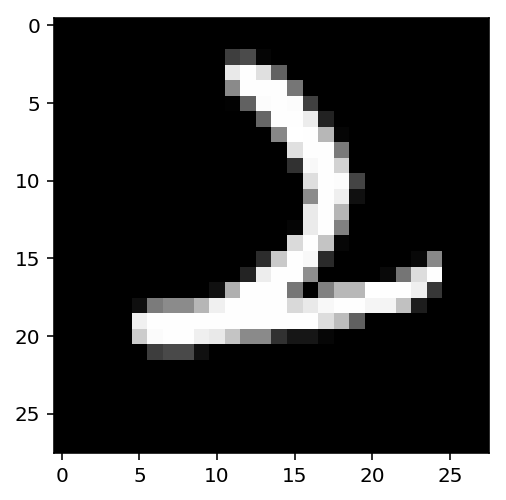

In [16]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r')

Primero vamos a revisar cómo construir una simple RNA para este conjunto de datos usando pesos `weights` y 
multiplicación de matrices. Después veremos cómo utilizar el módulo `nn` de PyTorch para agilizar el cálculo.

En una red completamente conectada (fully-connected) o también llamada red densa, cada neurona de cada capa está conectada a cada neurona de las siguientes capas. Entonces todas las entradas de cada capa deben ser un vector unidimensional. 

En nuestro caso tenemos imagenes de 28x28 pixeles, entonces debemos convertirlo a un vector unidimensional. Proyectando el tamaño del vector, será de tamaño 784 (28x28). Esta conversión se llama `flattening`.

En el ejercicio anterior teníamos una simple RNA con una única neurona de salida. En este caso requerimos 10 neuronas de salida para clasificar los 10 dígitos de nuestros `labels`.

# RNA 

## Problema

Convertir de 2D a 1D a través de `flattening` las imagenes `images`. Entonces construir una RNA multicapa con las siguientes caracteristicas: 
* 784 neuronas de entrada (28x28 pixeles) 
* 256 neuronas de operación en la capa oculta
* 10 neuronas de salida.


## Solución

Utilizar tensores aleatorios para los pesos `weights` y sesgos `bias`. Por ahora seguiremos utilizando la función de activación sigmoide.

In [0]:
def activation(x):
  return 1/(1+torch.exp(-x))

Creamos el contenedor de 2D -> 1D que serviran como entrada a la RNA a partir de nuestras imagenes

In [21]:
images.shape

torch.Size([64, 1, 28, 28])

In [18]:
inputs = images.view(images.shape[0], -1)#748
inputs

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]])

Cramos los parámetros pesos `weights` y sesgos `bias` con valores aleatorios

In [22]:
W1 = torch.randn(784, 256)
W1

tensor([[-0.2592,  0.6770, -1.2412,  ...,  0.8847,  0.4188,  1.9153],
        [ 0.4264, -0.9316, -0.8064,  ...,  0.1896, -0.4848,  1.4280],
        [ 1.9250,  1.6154, -0.3922,  ..., -1.5537, -1.0404,  0.8354],
        ...,
        [-0.3070,  0.4445,  0.7139,  ...,  0.9762,  1.3539, -1.6803],
        [ 0.8602,  0.6207,  1.5383,  ...,  1.5025, -1.1201, -0.2183],
        [-1.2521,  0.9270, -0.4456,  ...,  1.4104,  0.4199, -1.2772]])

In [23]:
W2 = torch.randn(256, 10)
W2

tensor([[-0.8065, -0.9373,  0.3554,  ...,  0.1062,  1.7810, -0.6692],
        [-1.6116,  1.6495, -1.5544,  ...,  0.8025, -0.0781,  0.2477],
        [-0.1455, -0.2576, -1.5280,  ...,  0.3326, -0.3540, -0.7238],
        ...,
        [ 1.6874, -0.7659,  0.4025,  ..., -0.7589, -1.4641,  1.6798],
        [-1.0245,  0.8975, -0.5665,  ...,  1.6548,  0.1798,  0.5534],
        [ 0.2045,  0.3932, -0.3048,  ..., -0.1322, -0.3805,  0.5560]])

In [24]:
B1 = torch.randn(256)
B1

tensor([-2.6959e-01, -6.4401e-01,  1.5304e+00,  4.4925e-01, -1.1948e-01,
         1.3948e+00,  2.4756e+00,  1.9185e-01,  4.5823e-01,  4.1869e-01,
         6.7490e-01,  3.6038e-02, -1.9226e+00, -1.4161e+00, -7.1506e-02,
         2.7481e-01, -1.6912e+00,  1.1585e+00,  7.6433e-01,  3.4895e-01,
        -1.3445e-01, -3.6799e-01,  2.6727e-01,  6.5495e-01, -1.7657e+00,
        -1.1383e+00, -4.1337e-01, -3.6668e-01,  4.9147e-01, -1.5289e+00,
        -1.2815e+00,  9.3821e-01,  8.6951e-01, -6.1774e-01, -1.1655e-02,
        -4.0782e-01,  6.1863e-02, -8.0903e-01, -7.6594e-01,  1.9255e+00,
        -7.7985e-01, -4.3084e-01,  1.7867e+00,  4.6749e-01,  7.9599e-01,
        -1.4677e+00, -1.0446e+00, -2.0511e-01, -5.8940e-01,  1.3537e+00,
        -9.2334e-01, -1.0935e+00, -1.5050e+00, -1.8980e+00, -4.6774e-01,
        -1.5996e+00,  9.1733e-01, -1.1695e+00, -1.3600e+00,  6.2143e-01,
         1.6258e+00, -1.5024e-01, -1.1203e+00, -9.8463e-01,  3.4021e-02,
         2.1195e+00,  8.2358e-01, -1.1446e+00, -2.0

In [25]:
B2 = torch.randn(10)
B2

tensor([-0.3139, -0.7479, -0.2983, -1.3433,  0.6957,  0.1375, -0.5109,  0.3100,
        -0.2807, -0.5398])

In [26]:
h = activation(torch.mm(inputs, W1) + B1)
h

tensor([[1.0000e+00, 1.7669e-03, 9.0182e-01,  ..., 9.8231e-01, 1.2848e-07,
         1.0000e+00],
        [1.0000e+00, 9.9764e-01, 6.0160e-01,  ..., 6.0020e-02, 1.0000e+00,
         1.0000e+00],
        [1.0000e+00, 1.0000e+00, 8.7951e-03,  ..., 9.9991e-01, 4.9174e-03,
         9.8722e-01],
        ...,
        [1.0000e+00, 9.6994e-01, 1.9901e-02,  ..., 1.0000e+00, 9.9578e-01,
         1.0000e+00],
        [1.0000e+00, 9.9984e-01, 9.8795e-01,  ..., 1.0000e+00, 1.0512e-10,
         7.9517e-03],
        [1.0000e+00, 1.0000e+00, 9.9999e-01,  ..., 1.0000e+00, 9.9987e-01,
         8.6819e-01]])

In [28]:
out = torch.mm(h, W2) + B2
out.shape

torch.Size([64, 10])

Ahora que tenemos las 10 neuronas de salida, podemos clasificar nuestras imagenes (a través de los vectores 1D de 728 pixeles) y obtener una distribución de probabilidad de las clases para que la RNA nos diga cuál dígito es:


<img src="https://docs.google.com/uc?export=download&id=1gd_YRsW-6fpsncrZhj67adFwe1WLO851" height= "250">

En esta imagen se puede ver que la probabilidad es casi la misma, es difícil para la RNA definir cuál número es. Esto representa una RNA no entrenada, aún no ha visto ningún dato, por lo que solo devuelve una distribución uniforme con probabilidades iguales para cada clase.

Para calcular entonces la distribución de probabilidad, usaremos la función `softmax`:

$$
\Large \sigma(x_i) = \cfrac{e^{x_i}}{\sum_k^K{e^{x_k}}}
$$

Lo que esto hace es "aplastar" cada entrada $x_1$ entre $0$ y $1$ y normaliza los valores para darle una distribución de probabilidad adecuada donde las probabilidades suman uno.



## Problema

Implementar la función `softmax` para encontrar la distribución de probabilidad para cada ejemplo en el batch

## Solución

In [0]:
def softmax(x):
  return torch.exp(x)/torch.sum(torch.exp(x), dim=1).view(-1, 1)#748x1

In [31]:
probabilities = softmax(out)
probabilities.shape

torch.Size([64, 10])

El tamaño de las `probabilities` debe ser de `([64,10])` 

In [32]:
probabilities.shape

torch.Size([64, 10])

La suma de las probabilidades debe dar 1

In [33]:
probabilities.sum(dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])

## Problema

Construir una RNA utilizando el módulo nn para crear redes de manera más simple. Recordando las características de nuestra RNA:
* 784 neuronas de entrada `inputs` (64x64 pixeles de 2D -> 1D)
* 256 neuronas de operación en la capa oculta
* 10 neuronas en la capa de salida
* Implementar la función `softmax`

In [0]:
from torch import nn

In [0]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    
    #Definimos las 784 neuronas de operación en la capa oculta en un vector de 1D
    self.hidden = nn.Linear(784, 256)
    
    #Definimos las 10 neuronas en la capa de salida e implementamos `softmax`
    self.output = nn.Linear(256, 10)
    
    #Definimos las funciones de activación sigmoide y softmax
    self.sigmoid = nn.Sigmoid()
    self.softmax = nn.Softmax(dim=1)
    
  def forward(self, x):
    
    #Procesamos las entradas 
    x = self.hidden(x)
    x = self.sigmoid(x)
    x = self.output(x)
    x = self.softmax(x)
    
    return x

Yendo paso por paso en lo que acabamos de hacer

```python 
class Network(nn.Module):
```
Nos permite heredar las propiedades de `nn.Module`. Combinado con `super().__init__` creamos una clase que genera una arquitectura y métodos y atributos.

```python
self.hidden = nn.Linear(784, 256)
```
Crea un módulo para la transformación lineal $xW+b$, con 784 neuronas de entrada y 256 neuronas de operación en la capa oculta, asignada a `self.hidden`. El módulo automáticamente crea los tensores con los pesos `weights` y sesgos `bias` a través del método `forward`. Una vez que se crearon los tensores de los parámetros, podemos acceder a ellos a través de `Network.hidden.weight` y `Network.hidden.bias`.

```python
self.output = nn.Linear(256, 10)
```
Crea otra transformación lineal con 256 neuronas de operación salientes de la capa oculta y 10 neuronas de la capa de salida.

```python
self.sigmoid = nn.Sigmoid()
self.softmax = nn.Sofmax(dim=1)
```

Define las funciones de activación Sigmoide y softmax, dando como parámetro de la función `dim=1` nos aseguramos que el cálculo sea a través de las columnas.

```python
def forward(self,x):
```
Las RNA creadas con `nn.Module` deben tener un método `forward` definido. Esto toma al tensor `x` y ejecuta las operaciones definidas en el método `__init__`.

```python
x = self.hidden(x)
x = self.sigmoid(x)
x = self.output(x)
x = self.softmax(x)
```

Aquí el tensor de entrada `x` es sometida a la ejecución de las operaciones y reasignado el valor a `x`.

Ahora podemos crear el objeto `Network`.

In [36]:
model = Network()
model

Network(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax()
)

Podemos mejorar nuestra RNA de forma más consisa y limpia utilizando el módulo `torch.nn.functional`. 

In [0]:
import torch.nn.functional as F

In [0]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    
    #Definimos las 784 neuronas de operación en la capa oculta en un vector de 1D
    self.hidden = nn.Linear(784, 256)
    
    #Definimos las 10 neuronas en la capa de salida e implementamos `softmax`
    self.output = nn.Linear(256, 10)
    
    
  def forward(self, x):
    
    #Procesamos las entradas 
    x = F.sigmoid(self.hidden(x))
    x = F.softmax(self.output(x), dim=1)
    
    return x

## Funciones de activación
Hasta ahora hemos visto las funciones de activación Sigmoide y Softmax, pero en general cualquier función podría servir. El único requisito es que para que una RNA se aproxime a una función no lineal, la función de activación debe ser de la misma naturaleza no lineal. Aquí hay algunas opciones:

<img src="https://docs.google.com/uc?export=download&id=1D7klCWFOPDjySCaLus4QbMekle-T46qA" height= 250px>

## Problema

Construir la RNA con las siguientes características:


<img src="https://docs.google.com/uc?export=download&id=1Oevliiu-13fQBFSOLIkNIiE47nneeaGb" height= 250px>


Usar la función de activación ReLU a través del módulo `nn.ReLU` o la función `F.relu`.

## Solución

In [0]:
import torch.nn.functional as F

In [0]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    
    #Definimos el tamaño de las capas ocultas
    self.hidden_layer_1 = nn.Linear(784, 128)
    self.hidden_layer_2 = nn.Linear(128, 64)
    
    #Definimos el tamaño de la capa de salida
    self.output = nn.Linear(64, 10)
    
    
  def forward(self, x):
    #Definimos las operaciones
    x = self.hidden_layer_1(x)
    x = F.relu(x)
    x = self.hidden_layer_2(x)
    x = F.relu(x)
    x = self.output(x)
    x = F.softmax(x, dim=1)
    
    return x

Checamos nuestra RNA multicapa

In [41]:
model = Network()
model

Network(
  (hidden_layer_1): Linear(in_features=784, out_features=128, bias=True)
  (hidden_layer_2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
)

Los parámetros pesos `weights` y sesgos `bias`, se crean automáticamente como tensores a partir de `model`.

In [42]:
model.hidden_layer_1.weight

Parameter containing:
tensor([[ 0.0170,  0.0196, -0.0067,  ...,  0.0002,  0.0192,  0.0158],
        [ 0.0295,  0.0087, -0.0259,  ...,  0.0237, -0.0039, -0.0188],
        [-0.0212,  0.0186, -0.0133,  ...,  0.0354,  0.0306, -0.0343],
        ...,
        [ 0.0072, -0.0104, -0.0106,  ...,  0.0353, -0.0119, -0.0278],
        [-0.0261,  0.0074, -0.0127,  ...,  0.0013,  0.0096,  0.0257],
        [-0.0257, -0.0198,  0.0190,  ...,  0.0283,  0.0213,  0.0268]],
       requires_grad=True)

In [43]:
model.hidden_layer_1.bias

Parameter containing:
tensor([-1.4791e-02, -1.6827e-02,  2.7644e-02, -2.6681e-03,  5.1919e-05,
        -2.9128e-02, -8.0989e-03, -2.3103e-02, -2.8544e-02, -7.4148e-03,
         4.0243e-03, -2.4847e-02,  2.5300e-02, -2.9093e-02,  3.0386e-02,
         1.8472e-02, -8.0335e-03, -3.0500e-02,  2.6112e-02,  3.5656e-02,
        -4.2338e-03, -2.3036e-02, -1.4377e-03,  3.1833e-02,  1.4567e-02,
        -2.7342e-02,  1.6961e-02, -9.5159e-03,  1.1003e-02, -2.7952e-02,
        -4.4448e-03, -1.7759e-02,  2.9345e-02, -1.2898e-02,  3.2208e-03,
         2.5668e-02, -2.5551e-02,  3.7315e-03,  1.6452e-02, -3.1142e-02,
         2.1744e-02, -3.4685e-02, -2.8695e-02,  2.4576e-02,  2.1899e-02,
         1.6705e-02, -1.0291e-02,  1.7685e-02,  1.0228e-02, -2.9443e-02,
        -1.5828e-02,  2.6742e-02,  8.0777e-03, -2.9812e-02, -5.0579e-04,
        -2.5665e-02,  1.0542e-02,  6.6381e-05,  2.5878e-02, -2.3066e-02,
         3.1322e-02, -1.1893e-02, -3.0849e-02,  2.3050e-02,  2.5707e-02,
        -2.2174e-02,  1.8743e

Si quisieramos modificar los parámetros podríamos hacerlo a través de `model.hidden_layer_1.weight.data`

In [44]:
model.hidden_layer_1.weight.data

tensor([[ 0.0170,  0.0196, -0.0067,  ...,  0.0002,  0.0192,  0.0158],
        [ 0.0295,  0.0087, -0.0259,  ...,  0.0237, -0.0039, -0.0188],
        [-0.0212,  0.0186, -0.0133,  ...,  0.0354,  0.0306, -0.0343],
        ...,
        [ 0.0072, -0.0104, -0.0106,  ...,  0.0353, -0.0119, -0.0278],
        [-0.0261,  0.0074, -0.0127,  ...,  0.0013,  0.0096,  0.0257],
        [-0.0257, -0.0198,  0.0190,  ...,  0.0283,  0.0213,  0.0268]])

Una vez creada la RNA, vamos a entrenarla con una imagen

In [50]:
dataiter = iter(trainloader)
dataiter

In [0]:
images, labels = dataiter.next()

Convertimos las imágenes de 2D a un vector 1D, con el tamaño del batch (64), canal de color (1) y tamaño de pixeles (64x64 o 784 pixeles)

In [52]:
images.resize_(64, 1, 784)

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.]],

        ...,

        [[-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.]]])

In [54]:
img_idx = 0
rna = model.forward(images[img_idx, :])
rna

tensor([[0.0976, 0.0875, 0.1082, 0.0971, 0.1085, 0.0954, 0.0874, 0.1050, 0.1044,
         0.1089]], grad_fn=<SoftmaxBackward>)

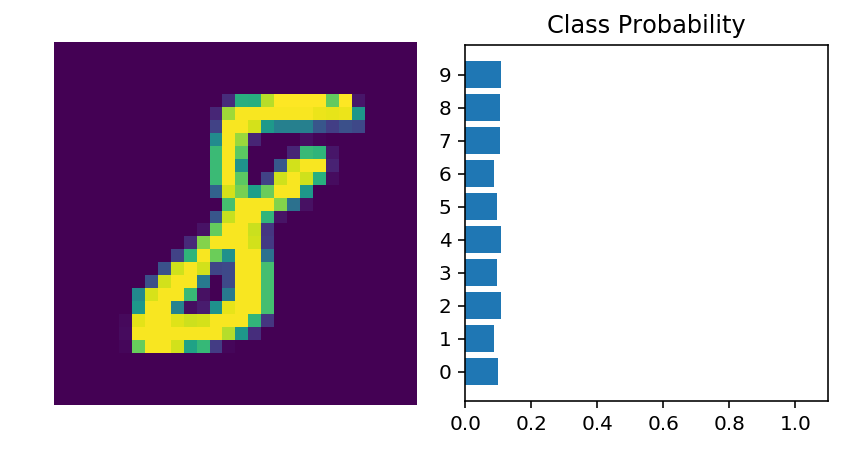

In [55]:
img = images[img_idx]
helper.view_classify(img.view(1,28,28), rna)

Como se puede observar, la RNA no tiene idea cuál es cuál dígito, lo interpreta como equiproblable. La respuesta es que los pesos `weights` son aleatorios.

Usando `nn.Sequential`

Definiendo los hyperparámetros de la RNA

In [0]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

Construtyendo la RNA

In [59]:
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                     nn.ReLU(),
                     nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                     nn.ReLU(),
                     nn.Linear(hidden_sizes[1], output_size),
                     nn.Softmax(dim=1))

model

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax()
)

Pasando hacia adelante a través de la RNA

In [0]:
images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 1, 784)

In [61]:
rna = model.forward(images[0,:])
rna

tensor([[0.1109, 0.1064, 0.0867, 0.0794, 0.0986, 0.0965, 0.0990, 0.1059, 0.1106,
         0.1060]], grad_fn=<SoftmaxBackward>)

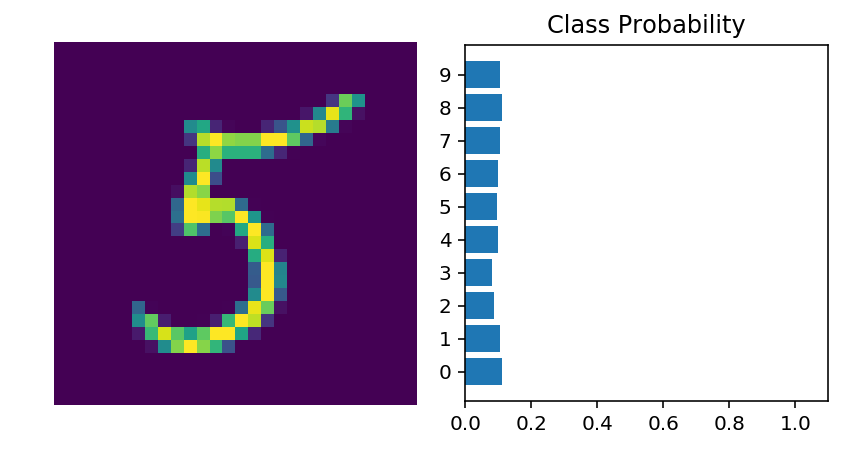

In [62]:
helper.view_classify(images[0].view(1,28,28), rna)

In [66]:
model[0].weight

Parameter containing:
tensor([[ 0.0077,  0.0067, -0.0131,  ...,  0.0268, -0.0105, -0.0159],
        [ 0.0331, -0.0144,  0.0146,  ..., -0.0159,  0.0327,  0.0164],
        [ 0.0219,  0.0205, -0.0075,  ..., -0.0021, -0.0034, -0.0216],
        ...,
        [-0.0176,  0.0224, -0.0155,  ..., -0.0027, -0.0262, -0.0013],
        [ 0.0008, -0.0015,  0.0008,  ..., -0.0101,  0.0209, -0.0031],
        [-0.0199,  0.0315, -0.0276,  ...,  0.0270, -0.0099, -0.0229]],
       requires_grad=True)

In [0]:
model[0].bias

Se puede también pasar un diccionario que permite nombrar las capas individuales y sus operaciones

In [0]:
from collections import OrderedDict

In [71]:
model = nn.Sequential(OrderedDict([
    ('hidden_layer_1', nn.Linear(input_size, hidden_sizes[0])),
    ('relu_1', nn.ReLU()),
    ('hidden_layer_2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
    ('relu_2', nn.ReLU()),
    ('output', nn.Linear(hidden_sizes[1], output_size)),
    ('softmax', nn.Softmax(dim=1))
    
]))

model

Sequential(
  (hidden_layer_1): Linear(in_features=784, out_features=128, bias=True)
  (relu_1): ReLU()
  (hidden_layer_2): Linear(in_features=128, out_features=64, bias=True)
  (relu_2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax()
)

Ahora se puede tener acceso a las capas a través de su posición o su nombre

In [72]:
model[0]

Linear(in_features=784, out_features=128, bias=True)

In [73]:
model.hidden_layer_1

Linear(in_features=784, out_features=128, bias=True)